## Seminar: Monte-carlo tree search (5 pts)

Monte Carlo tree search (MCTS) is a heuristic search algorithm, which shows cool results in challenging domains such as Go and chess. The algorithm builds a search tree, iteratively traverses it, and evaluates its nodes using a Monte-Carlo simulation.

In this seminar, we'll implement a MCTS([[1]](#1), [[2]](#2)) planning and use it to solve some Gym envs.

![image.png](https://i.postimg.cc/6QmwnjPS/image.png)

__How it works?__
We just start with an empty tree and expand it. There are several common procedures.

__1) Selection__
Starting from the root, recursively select the node that corresponds to the tree policy.  

There are several options for tree policies, which we saw earlier as exploration strategies: epsilon-greedy, Thomson sampling, UCB-1. It was shown that in MCTS, UCB-1 achieves a good result. Further, we will consider the one, but you can try to use others.

Following the UCB-1 tree policy, we will choose an action that, on one hand, we expect to have the highest return, and on the other hand, we haven't explored much.

$$
\DeclareMathOperator*{\argmax}{arg\,max}
$$

$$
\dot{a} = \argmax_{a} \dot{Q}(s, a)
$$

$$
\dot{Q}(s, a) = Q(s, a) + C_p \sqrt{\frac{2 \log {N}}{n_a}}
$$

where: 
- $N$ - number of times we have visited state $s$,
- $n_a$ - number of times we have taken action $a$,
- $C_p$ - exploration balance parameter, which is performed between exploration and exploitation. 

Using Hoeffding inequality for rewards $R \in [0,1]$ it can be shown [[3]](#3) that optimal $C_p = 1/\sqrt{2}$. For rewards outside this range, the parameter should be tuned. We'll be using 10, but you can experiment with other values.

__2) Expansion__
After the selection procedure, we can achieve a leaf node or node in which we don't complete actions. In this case, we expand the tree by feasible actions and get new state nodes. 

__3) Simulation__
How we can estimate node Q-values? The idea is to estimate action values for a given _rollout policy_ by averaging the return of many simulated trajectories from the current node. Simply, we can play with random or some special policy or use some model that can estimate it.

__4) Backpropagation__
The reward of the last simulation is backed up through the traversed nodes and propagates Q-value estimations, upwards to the root.

$$
Q({\text{parent}}, a) = r + \gamma \cdot Q({\text{child}}, a)
$$

There are a lot modifications of MCTS, more details about it you can find in this paper [[4]](#4)

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

But before we do that, we first need to make a wrapper for Gym environments to allow saving and loading game states to facilitate backtracking.

In [ ]:
import gym
from gym.core import Wrapper
from pickle import dumps, loads
from collections import namedtuple

# a container for get_result function below. Works just like tuple, but prettier
ActionResult = namedtuple(
    "action_result", ("snapshot", "observation", "reward", "is_done", "info"))


class WithSnapshots(Wrapper):
    """
    Creates a wrapper that supports saving and loading environemnt states.
    Required for planning algorithms.

    This class will have access to the core environment as self.env, e.g.:
    - self.env.reset()           #reset original env
    - self.env.ale.cloneState()  #make snapshot for atari. load with .restoreState()
    - ...

    You can also use reset() and step() directly for convenience.
    - s = self.reset()                   # same as self.env.reset()
    - s, r, done, _ = self.step(action)  # same as self.env.step(action)
    
    Note that while you may use self.render(), it will spawn a window that cannot be pickled.
    Thus, you will need to call self.close() before pickling will work again.
    """

    def get_snapshot(self, render=False):
        """
        :returns: environment state that can be loaded with load_snapshot 
        Snapshots guarantee same env behaviour each time they are loaded.

        Warning! Snapshots can be arbitrary things (strings, integers, json, tuples)
        Don't count on them being pickle strings when implementing MCTS.

        Developer Note: Make sure the object you return will not be affected by 
        anything that happens to the environment after it's saved.
        You shouldn't, for example, return self.env. 
        In case of doubt, use pickle.dumps or deepcopy.

        """
        if render:
            self.render()  # close popup windows since we can't pickle them
            self.close()
            
        if self.unwrapped.viewer is not None:
            self.unwrapped.viewer.close()
            self.unwrapped.viewer = None
        return dumps(self.env)

    def load_snapshot(self, snapshot, render=False):
        """
        Loads snapshot as current env state.
        Should not change snapshot inplace (in case of doubt, deepcopy).
        """

        assert not hasattr(self, "_monitor") or hasattr(
            self.env, "_monitor"), "can't backtrack while recording"

        if render:
            self.render()  # close popup windows since we can't load into them
            self.close()
        self.env = loads(snapshot)

    def get_result(self, snapshot, action):
        """
        A convenience function that 
        - loads snapshot, 
        - commits action via self.step,
        - and takes snapshot again :)

        :returns: next snapshot, next_observation, reward, is_done, info

        Basically it returns next snapshot and everything that env.step would have returned.
        """

        # <YOUR CODE: load, commit, take snapshot>
        self.load_snapshot(snapshot)
        next_observation, reward, is_done, info = self.env.step(action)
        next_snapshot = self.get_snapshot()

        return ActionResult(
            next_snapshot,    #<YOUR CODE: next_snapshot>,  # fill in the variables
            next_observation, #<YOUR CODE: next_observation>,
            reward,           #<YOUR CODE: reward>,
            is_done,          #<YOUR CODE: is_done>,
            info,             #<YOUR CODE: info>,
        )

### Try out snapshots:
Let`s check our wrapper. At first, reset environment and save it, further randomly play some actions and restore our environment from the snapshot. It should be the same as our previous initial state.

In [ ]:
# make env
env = WithSnapshots(gym.make("CartPole-v0"))
env.reset()

n_actions = env.action_space.n

initial_state:


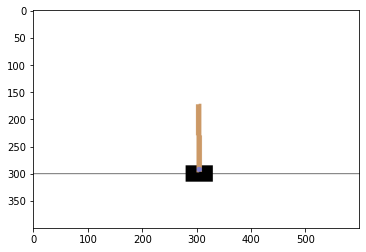

In [ ]:
print("initial_state:")
plt.imshow(env.render('rgb_array'))
env.close()

# create first snapshot
snap0 = env.get_snapshot()

Whoops! We died!
final state:


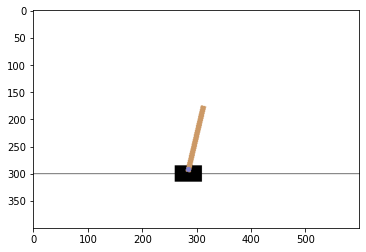

In [ ]:
# play without making snapshots (faster)
while True:
    is_done = env.step(env.action_space.sample())[2]
    if is_done:
        print("Whoops! We died!")
        break

print("final state:")
plt.imshow(env.render('rgb_array'))
env.close()



After loading snapshot


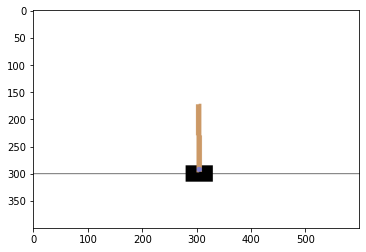

In [ ]:
# reload initial state
env.load_snapshot(snap0)

print("\n\nAfter loading snapshot")
plt.imshow(env.render('rgb_array'))
env.close()

In [ ]:
# get outcome (snapshot, observation, reward, is_done, info)
res = env.get_result(snap0, env.action_space.sample())

snap1, observation, reward = res[:3]

# second step
res2 = env.get_result(snap1, env.action_space.sample())

# MCTS: Monte-Carlo tree search


We will start by implementing the `Node` class - a simple class that acts like MCTS node and supports some of the MCTS algorithm steps.

This MCTS implementation makes some assumptions about the environment, you can find those _in the notes section at the end of the notebook_.

In [ ]:
assert isinstance(env, WithSnapshots)

In [ ]:
class Node:
    """A tree node for MCTS.
    
    Each Node corresponds to the result of performing a particular action (self.action)
    in a particular state (self.parent), and is essentially one arm in the multi-armed bandit that
    we model in that state."""

    # metadata:
    parent = None  # parent Node
    qvalue_sum = 0.  # sum of Q-values from all visits (numerator)
    times_visited = 0  # counter of visits (denominator)

    def __init__(self, parent, action):
        """
        Creates and empty node with no children.
        Does so by commiting an action and recording outcome.

        :param parent: parent Node
        :param action: action to commit from parent Node
        """

        self.parent = parent
        self.action = action
        self.children = set()  # set of child nodes

        # get action outcome and save it
        res = env.get_result(parent.snapshot, action)
        self.snapshot, self.observation, self.immediate_reward, self.is_done, _ = res

    def is_leaf(self):
        return len(self.children) == 0

    def is_root(self):
        return self.parent is None

    def get_qvalue_estimate(self):
        return self.qvalue_sum / self.times_visited if self.times_visited != 0 else 0

    def ucb_score(self, scale=10, max_value=1e100):
        """
        Computes ucb1 upper bound using current value and visit counts for node and it's parent.

        :param scale: Multiplies upper bound by that. From Hoeffding inequality,
                      assumes reward range to be [0, scale].
        :param max_value: a value that represents infinity (for unvisited nodes).

        """

        if self.times_visited == 0:
            return max_value

        # compute ucb-1 additive component (to be added to mean value)
        # hint: you can use self.parent.times_visited for N times node was considered,
        # and self.times_visited for n times it was visited

        # U = <YOUR CODE>
        N_s = self.parent.times_visited
        N_sa = self.times_visited
        U = np.sqrt(2 * np.log(N_s) / N_sa)

        return self.get_qvalue_estimate() + scale * U

    # MCTS steps

    def select_best_leaf(self):
        """
        Picks the leaf with the highest priority to expand.
        Does so by recursively picking nodes with the best UCB-1 score until it reaches a leaf.
        """
        if self.is_leaf():
            return self

        children = self.children

        # Select the child node with the highest UCB score. You might want to implement some heuristics
        # to break ties in a smart way, although CartPole should work just fine without them.
        # best_child = <YOUR CODE>
        best_child = max(children, key=Node.ucb_score)

        return best_child.select_best_leaf()

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.
        Then returns one of those children.
        """

        assert not self.is_done, "can't expand from terminal state"

        for action in range(n_actions):
            self.children.add(Node(self, action))

        # If you have implemented any heuristics in select_best_leaf(), they will be used here.
        # Otherwise, this is equivalent to picking some undefined newly created child node.
        return self.select_best_leaf()

    def rollout(self, t_max=10**4):
        """
        Play the game from this state to the end (done) or for t_max steps.

        On each step, pick action at random (hint: env.action_space.sample()).

        Compute sum of rewards from the current state until the end of the episode.
        Note 1: use env.action_space.sample() for picking a random action.
        Note 2: if the node is terminal (self.is_done is True), just return self.immediate_reward.

        """

        # set env into the appropriate state
        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done

        # <YOUR CODE: perform rollout and compute reward>
        rollout_reward = 0.
        for i in range(t_max):
            if is_done:
                break
            s, r, is_done, _ = env.step(env.action_space.sample())
            rollout_reward += r
        return rollout_reward

    def propagate(self, child_qvalue):
        """
        Uses child Q-value (sum of rewards) to update parents recursively.
        """
        # compute node Q-value
        my_qvalue = self.immediate_reward + child_qvalue

        # update qvalue_sum and times_visited
        self.qvalue_sum += my_qvalue
        self.times_visited += 1

        # propagate upwards
        if not self.is_root():
            self.parent.propagate(my_qvalue)

    def safe_delete(self):
        """safe delete to prevent memory leak in some python versions"""
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

In [ ]:
class Root(Node):
    def __init__(self, snapshot, observation):
        """
        creates special node that acts like tree root
        :snapshot: snapshot (from env.get_snapshot) to start planning from
        :observation: last environment observation
        """

        self.parent = self.action = None
        self.children = set()  # set of child nodes

        # root: load snapshot and observation
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False

    @staticmethod
    def from_node(node):
        """initializes node as root"""
        root = Root(node.snapshot, node.observation)
        # copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root

## Main MCTS loop

With all we implemented, MCTS boils down to a trivial piece of code.

In [ ]:
def plan_mcts(root, n_iters=10):
    """
    builds tree with monte-carlo tree search for n_iters iterations
    :param root: tree node to plan from
    :param n_iters: how many select-expand-simulate-propagete loops to make
    """
    for _ in range(n_iters):
        # node = <YOUR CODE: select best leaf>
        node = root.select_best_leaf()

        if node.is_done:
            # All rollouts from a terminal node are empty, and thus have 0 reward.
            node.propagate(0)
        else:
            # Expand the best leaf. Perform a rollout from it. Propagate the results upwards.
            # Note that here you have some leeway in choosing where to propagate from.
            # Any reasonable choice should work.
            # <YOUR CODE> 
            child_node = node.expand()
            reward = child_node.rollout()
            child_node.propagate(reward)

## Plan and execute

Let's use our MCTS implementation to find the optimal policy.

In [ ]:
env = WithSnapshots(gym.make("CartPole-v0"))
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)

In [ ]:
# plan from root:
plan_mcts(root, n_iters=1000)

In [ ]:
next(iter(root.children)).times_visited

995

In [ ]:
# import copy
# saved_root = copy.deepcopy(root)
# root = saved_root

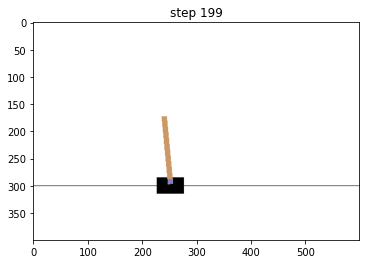

Finished with reward =  200.0
CPU times: user 49.6 s, sys: 1.06 s, total: 50.7 s
Wall time: 50.4 s


In [ ]:
%%time
from IPython.display import clear_output
from itertools import count
from gym.wrappers import Monitor

total_reward = 0  # sum of rewards
test_env = loads(root_snapshot)  # env used to show progress

for i in count():

    # get best child
    # best_child = <YOUR CODE: select child with the highest mean reward>
    best_child = max(root.children, key=Node.ucb_score) 
    # test_env.select_best_leaf

    # take action
    s, r, done, _ = test_env.step(best_child.action)

    # show image
    clear_output(True)
    plt.title("step %i" % i)
    plt.imshow(test_env.render('rgb_array'))
    plt.show()

    total_reward += r
    if done:
        print("Finished with reward = ", total_reward)
        break

    # discard unrealized part of the tree [because not every child matters :(]
    for child in root.children:
        if child != best_child:
            child.safe_delete()

    # declare best child a new root
    root = Root.from_node(best_child)

    assert not root.is_leaf(), \
        "We ran out of tree! Need more planning! Try growing the tree right inside the loop."

    # You may want to run more planning here
    # <YOUR CODE>
    plan_mcts(root, n_iters=20)

## Bonus assignments (10+pts each)

There's a few things you might want to try if you want to dig deeper:

### Node selection and expansion

"Analyze this" assignment

UCB-1 is a weak bound as it relies on a very general bounds (Hoeffding Inequality, to be exact). 
* Try playing with the exploration parameter $C_p$. The theoretically optimal $C_p$ you can get from a max reward of the environment (max reward for CartPole is 200).
* Use using a different exploration strategy (bayesian UCB, for example)
* Expand not all but several random actions per `expand` call. See __the notes below__ for details.

The goal is to find out what gives the optimal performance for `CartPole-v0` for different time budgets (i.e. different n_iter in plan_mcts.)

Evaluate your results on `Acrobot-v1` - do the results change and if so, how can you explain it?


### Atari-RAM

"Build this" assignment

Apply MCTS to play Atari games. In particular, let's start with ```gym.make("MsPacman-ramDeterministic-v0")```.

This requires two things:
* Slightly modify WithSnapshots wrapper to work with atari.

 * Atari has a special interface for snapshots:
   ```   
   snapshot = self.env.ale.cloneState()
   ...
   self.env.ale.restoreState(snapshot)
   ```
 * Try it on the env above to make sure it does what you told it to.
 
* Run MCTS on the game above. 
 * Start with small tree size to speed-up computations
 * You will probably want to rollout for 10-100 steps (t_max) for starters
 * Consider using discounted rewards (see __notes at the end__)
 * Try a better rollout policy
 
 
### Integrate learning into planning

Planning on each iteration is a costly thing to do. You can speed things up drastically if you train a classifier to predict which action will turn out to be best according to MCTS.

To do so, just record which action did the MCTS agent take on each step and fit something to [state, mcts_optimal_action]
* You can also use optimal actions from discarded states to get more (dirty) samples. Just don't forget to fine-tune without them.
* It's also worth a try to use P(best_action|state) from your model to select best nodes in addition to UCB
* If your model is lightweight enough, try using it as a rollout policy.

__(bonus points)__ While CartPole is glorious enough, try expanding this to ```gym.make("MsPacmanDeterministic-v0")```
* See previous section on how to wrap atari (you'll get points for both if you run this on atari)


### Integrate planning into learning (project, a LOT of points)

Incorporate planning into the agent architecture. 

The goal is to implement [Value Iteration Networks](https://arxiv.org/abs/1602.02867)

You will need to implement a special layer that performs value iteration-like update to a recurrent memory. This can be implemented the same way you did in the POMDP assignment.

## Notes


#### Assumptions

The full list of assumptions is:

* __Finite number of actions__: we enumerate all actions in `expand`.
* __Episodic (finite) MDP__: while technically it works for infinite MDPs, we perform a rollout for $10^4$ steps. If you are knowingly infinite, please adjust `t_max` to something more reasonable.
* __Deterministic MDP__: `Node` represents the single outcome of taking `self.action` in `self.parent`, and does not support the situation where taking an action in a state may lead to different rewards and next states.
* __No discounted rewards__: we assume $\gamma=1$. If that isn't the case, you only need to change two lines in `rollout()` and use `my_qvalue = self.immediate_reward + gamma * child_qvalue` for `propagate()`.
* __pickleable env__: won't work if e.g. your env is connected to a web-browser surfing the internet. For custom envs, you may need to modify get_snapshot/load_snapshot from `WithSnapshots`.

#### On `get_best_leaf` and `expand` functions

This MCTS implementation only selects leaf nodes for expansion.
This doesn't break things down because `expand` adds all possible actions. Hence, all non-leaf nodes are by design fully expanded and shouldn't be selected.

If you want to only add a few random action on each expand, you will also have to modify `get_best_leaf` to consider returning non-leafs.

#### Rollout policy

We use a simple uniform policy for rollouts. This introduces a negative bias to good situations that can be messed up completely with random bad action. As a simple example, if you tend to rollout with uniform policy, you better don't use sharp knives and walk near cliffs.

You can improve that by integrating a reinforcement _learning_ algorithm with a computationally light agent. You can even train this agent on optimal policy found by the tree search.

#### Contributions
* Reusing some code from 5vision [solution for deephack.RL](https://github.com/5vision/uct_atari), code by Mikhail Pavlov
* Using some code from [this gist](https://gist.github.com/blole/dfebbec182e6b72ec16b66cc7e331110)

#### References
* <a id="1">[1]</a> _Coulom R. (2007) Efficient Selectivity and Backup Operators in Monte-Carlo Tree Search. In: van den Herik H.J., Ciancarini P., Donkers H.H.L.M.. (eds) Computers and Games. CG 2006. Lecture Notes in Computer Science, vol 4630. Springer, Berlin, Heidelberg_

* <a id="2">[2]</a> _Kocsis L., Szepesvári C. (2006) Bandit Based Monte-Carlo Planning. In: Fürnkranz J., Scheffer T., Spiliopoulou M. (eds) Machine Learning: ECML 2006. ECML 2006. Lecture Notes in Computer Science, vol 4212. Springer, Berlin, Heidelberg_

* <a id="3">[3]</a> _Kocsis, Levente, Csaba Szepesvári, and Jan Willemson. "Improved monte-carlo search." Univ. Tartu, Estonia, Tech. Rep 1 (2006)._

* <a id="4">[4]</a> _C. B. Browne et al., "A Survey of Monte Carlo Tree Search Methods," in IEEE Transactions on Computational Intelligence and AI in Games, vol. 4, no. 1, pp. 1-43, March 2012, doi: 10.1109/TCIAIG.2012.2186810._